# [Day 16](https://adventofcode.com/2023/day/16)
## Part 1

In [1]:
from collections import defaultdict
from dataclasses import dataclass, field
from typing import Generic, TypeVar
from enum import Enum

class Direction(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3
    
    def reverse(self):
        return Direction((self.value + 2) % 4)

T = TypeVar('T')
@dataclass(unsafe_hash=True)
class Node(Generic[T]):
    x: int
    y: int
    type: str
    connected: dict[Direction, T] = field(default_factory=dict, init=False, compare=False, hash=False)

    def next(self, dir: Direction) -> list[tuple[Direction, T]]:
        dir = dir.reverse()
        if dir in self.connected:
            return [(dir, self.connected[dir])]
        else:
            return []
    
    def __repr__(self):
        return f'{self.__class__.__name__} {self.x} {self.y}'
    
@dataclass(unsafe_hash=True)
class Passthrough(Node[Node]):
    type: str = ' '
    pass

@dataclass(unsafe_hash=True)
class Mirror(Node[Node]):
    type: str

    def next(self, dir: Direction) -> list[tuple[Direction, T]]: 
        out: Direction
        # default case of \
        match dir:
            case Direction.UP:
                out = Direction.RIGHT
            case Direction.RIGHT:
                out = Direction.UP
            case Direction.DOWN:
                out = Direction.LEFT
            case Direction.LEFT:
                out = Direction.DOWN
        if self.type == '/':
            # flip the direction
            out = out.reverse()
        return [(out, self.connected[out])]
    
    def __repr__(self):
        return f'{super().__repr__()} {self.type}'
        

@dataclass(unsafe_hash=True)
class Splitter(Node[Node]):
    type: str

    def next(self, dir: Direction) -> list[tuple[Direction, T]]: 
        outs: list[Direction] = []
        match self.type:
            case '|':
                match dir:
                    case Direction.UP | Direction.DOWN:
                        return super().next(dir)
                    case Direction.LEFT | Direction.RIGHT:
                        outs = [Direction.UP, Direction.DOWN]
            case '-':
                match dir:
                    case Direction.RIGHT | Direction.LEFT:
                        return super().next(dir)
                    case Direction.UP | Direction.DOWN:
                        outs = [Direction.LEFT, Direction.RIGHT]
        return [(d, self.connected[d]) for d in outs]
    
    def __repr__(self):
        return f'{super().__repr__()} {self.type}'



def readInput(filename: str) -> (list[Node], list[list[str]], list[Node]):
    nodesTop: list[list[Node]] = None
    nodeLeft: Node = None
    nodes = []
    map: list[list[str]] = []
    edges: tuple[Direction, Node] = []
    with open(filename, 'r') as f:
        for y, line in enumerate(f):
            line = line.strip()

            # the first node will aways be (-1, 0)
            nodeLeft = Passthrough(-1, y)
            nodes.append(nodeLeft)
            edges.append((Direction.RIGHT, nodeLeft))
            map.append(list(line))
            if not nodesTop:
                nodesTop = [Passthrough(x, -1) for x in range(len(line))]
                nodes.extend(nodesTop)
                edges.extend([(Direction.DOWN, n) for n in nodesTop])
            
            for x, c in enumerate(line):
                node = None
                match c:
                    case '/' | '\\':
                        node = Mirror(x, y, c)
                    case '-' | '|':
                        node = Splitter(x, y, c)
                    case _:
                        pass
                if node:
                    nodes.append(node)
                    nodeLeft.connected[Direction.RIGHT] = node
                    node.connected[Direction.LEFT] = nodeLeft
                    nodesTop[x].connected[Direction.DOWN] = node
                    node.connected[Direction.UP] = nodesTop[x]
                    nodeLeft = node
                    nodesTop[x] = node

            nodeRight = Passthrough(len(line), y)
            edges.append((Direction.LEFT, nodeRight))
            nodeLeft.connected[Direction.RIGHT] = nodeRight
            nodeRight.connected[Direction.LEFT] = nodeLeft
            nodes.append(nodeRight)

    nodesBottom = [Passthrough(x, len(nodesTop)) for x in range(len(nodesTop))]
    edges.extend([(Direction.UP, n) for n in nodesBottom])
    nodes.extend(nodesBottom)
    for x, node in enumerate(nodesTop):
        node.connected[Direction.DOWN] = nodesBottom[x]
        nodesBottom[x].connected[Direction.UP] = node

    return nodes, map, edges



def castRay(dir: Direction, node: Node):
    targets = [(dir, node)]
    visited: set[tuple[Direction, Node]] = set()
    energized: dict[tuple[int, int], (str, list[Node])] = dict()
    while targets:
        target = targets.pop()
        
        dir, node = target
        visited.add(target)
        
        # dir is the direction it is coming from, so we need to reverse it to get the direction is it getting into the node
        newTargets = node.next(dir.reverse())
        newTargets = [t for t in newTargets if t not in visited]

        if not isinstance(node, Passthrough):
            energized[(node.x, node.y)] = (node.type, newTargets)

        for d, t in newTargets:
            match d:
                case Direction.UP:
                    energized.update([((node.x, y), ('^', [])) for y in range(node.y-1, t.y, -1)])
                case Direction.RIGHT:
                    energized.update([((x, node.y), ('>', [])) for x in range(node.x+1, t.x, 1)])
                case Direction.DOWN:
                    energized.update([((node.x, y), ('v', [])) for y in range(node.y+1, t.y, 1)])
                case Direction.LEFT:
                    energized.update([((x, node.y), ('<', [])) for x in range(node.x-1, t.x, -1)])

        visited.update(newTargets)
        targets.extend(newTargets)
    return energized
    
nodes, m, edges = readInput('input.txt')

startEdge = edges[0]
energized = castRay(*startEdge)

print(len(energized))
print()
[print(''.join(l)) for l in m]
print()

for i in range(0, len(m)):

    for j in range(0, len(m[0])):
        if (j, i) in energized:
            print(energized.get((j, i))[0], end='')
        else:
            print(' ', end='')
    print()
    

7074

\........../.......-........|....\.......-..\/....|................\........../.|..././........\.........../..
...............\..\................/............\................./................../.........\..|....|/|-...
.../..........................\.....|.............-.......././.......-.|..../|.....-\........-....../.........
|..........................-..........-......./............................-..|................-..............
.....|......../...../.......-.\..............................-........|............|/.../../........./........
..\...|..-......\.........-\.||........|./................\....\........-..\..................../..\....-...|.
.|...........|............-........./.-.................|.|....../...............|..../..-..-...\...........|.
..............\............................................................./......................./\....-...
./........|...\.\..|..-....\............................|........./.................|/...............-....

## Part 2

In [2]:
nodes, m, edges = readInput('input.txt')

startEdge = None
max = dict()
for edge in edges:
    energized = castRay(*edge)
    if len(energized) > len(max):
        max = energized
        startEdge = edge

energized = max
print(len(energized))
print()
for i in range(0, len(m)):

    for j in range(0, len(m[0])):
        if (j, i) in energized:
            print(energized.get((j, i))[0], end='')
        else:
            print(' ', end='')
    print()

7530

      ^  v^/<<<<<<<->>>>>>>>|^   \<<<<<<<-<<\/>>>>|     ^ ^^^ ^^^     ^^ ^   ^   ^     ^                      
<<<<<<^<<<^v<<<\<<\^        v^      ^     ^ ^^    v     ^ ^^^ ^^^     ^^ ^   ^   ^     ^                      
   /<<^<<<^v<<<^<<<<<<<<<<<<v^\     |<<<<<^<^<<<<<->>>>>^>^/^/^^^<<<<-^| ^   |   ^     ^                      
   v  ^  v^v ^ ^  ^^        v^^     v     ^ ^^          ^ ^ ^v^^^    ^^v ^   ^   ^     ^                      
   v  ^  v^v ^ ^  ^^/<<<<<<<->\<<<<<<<<<<<^<^<<<<<<<<<<<^<^<^-^^>>>>>>|v ^   ^   ^     ^             />>>>>>>>
   v  |<<-^v>^>^\ ^^v        ||     v     ^ ^^          ^ \<<<<\<<<<<<<<->>\ ^   ^     ^             ^        
   v  v   ^v |<^<<^<v<<<<<-<<^v<<<<</>->>>>>>>>>>>>>>>>>|   ^^^^^    ^^v^^ v ^   |     ^             ^        
<<<<<<v<<<<v<<\^v ^^v        ^v     ^     ^ ^^          v   ^^^^^    ^^v^^ v ^   ^     ^             \<<<<->>>
   v  v   |v v\<\>^|v        ^v     ^     ^ ^^          |   ^^^^^    ^^v^^ v ^   ^     ^                  

# Graph view

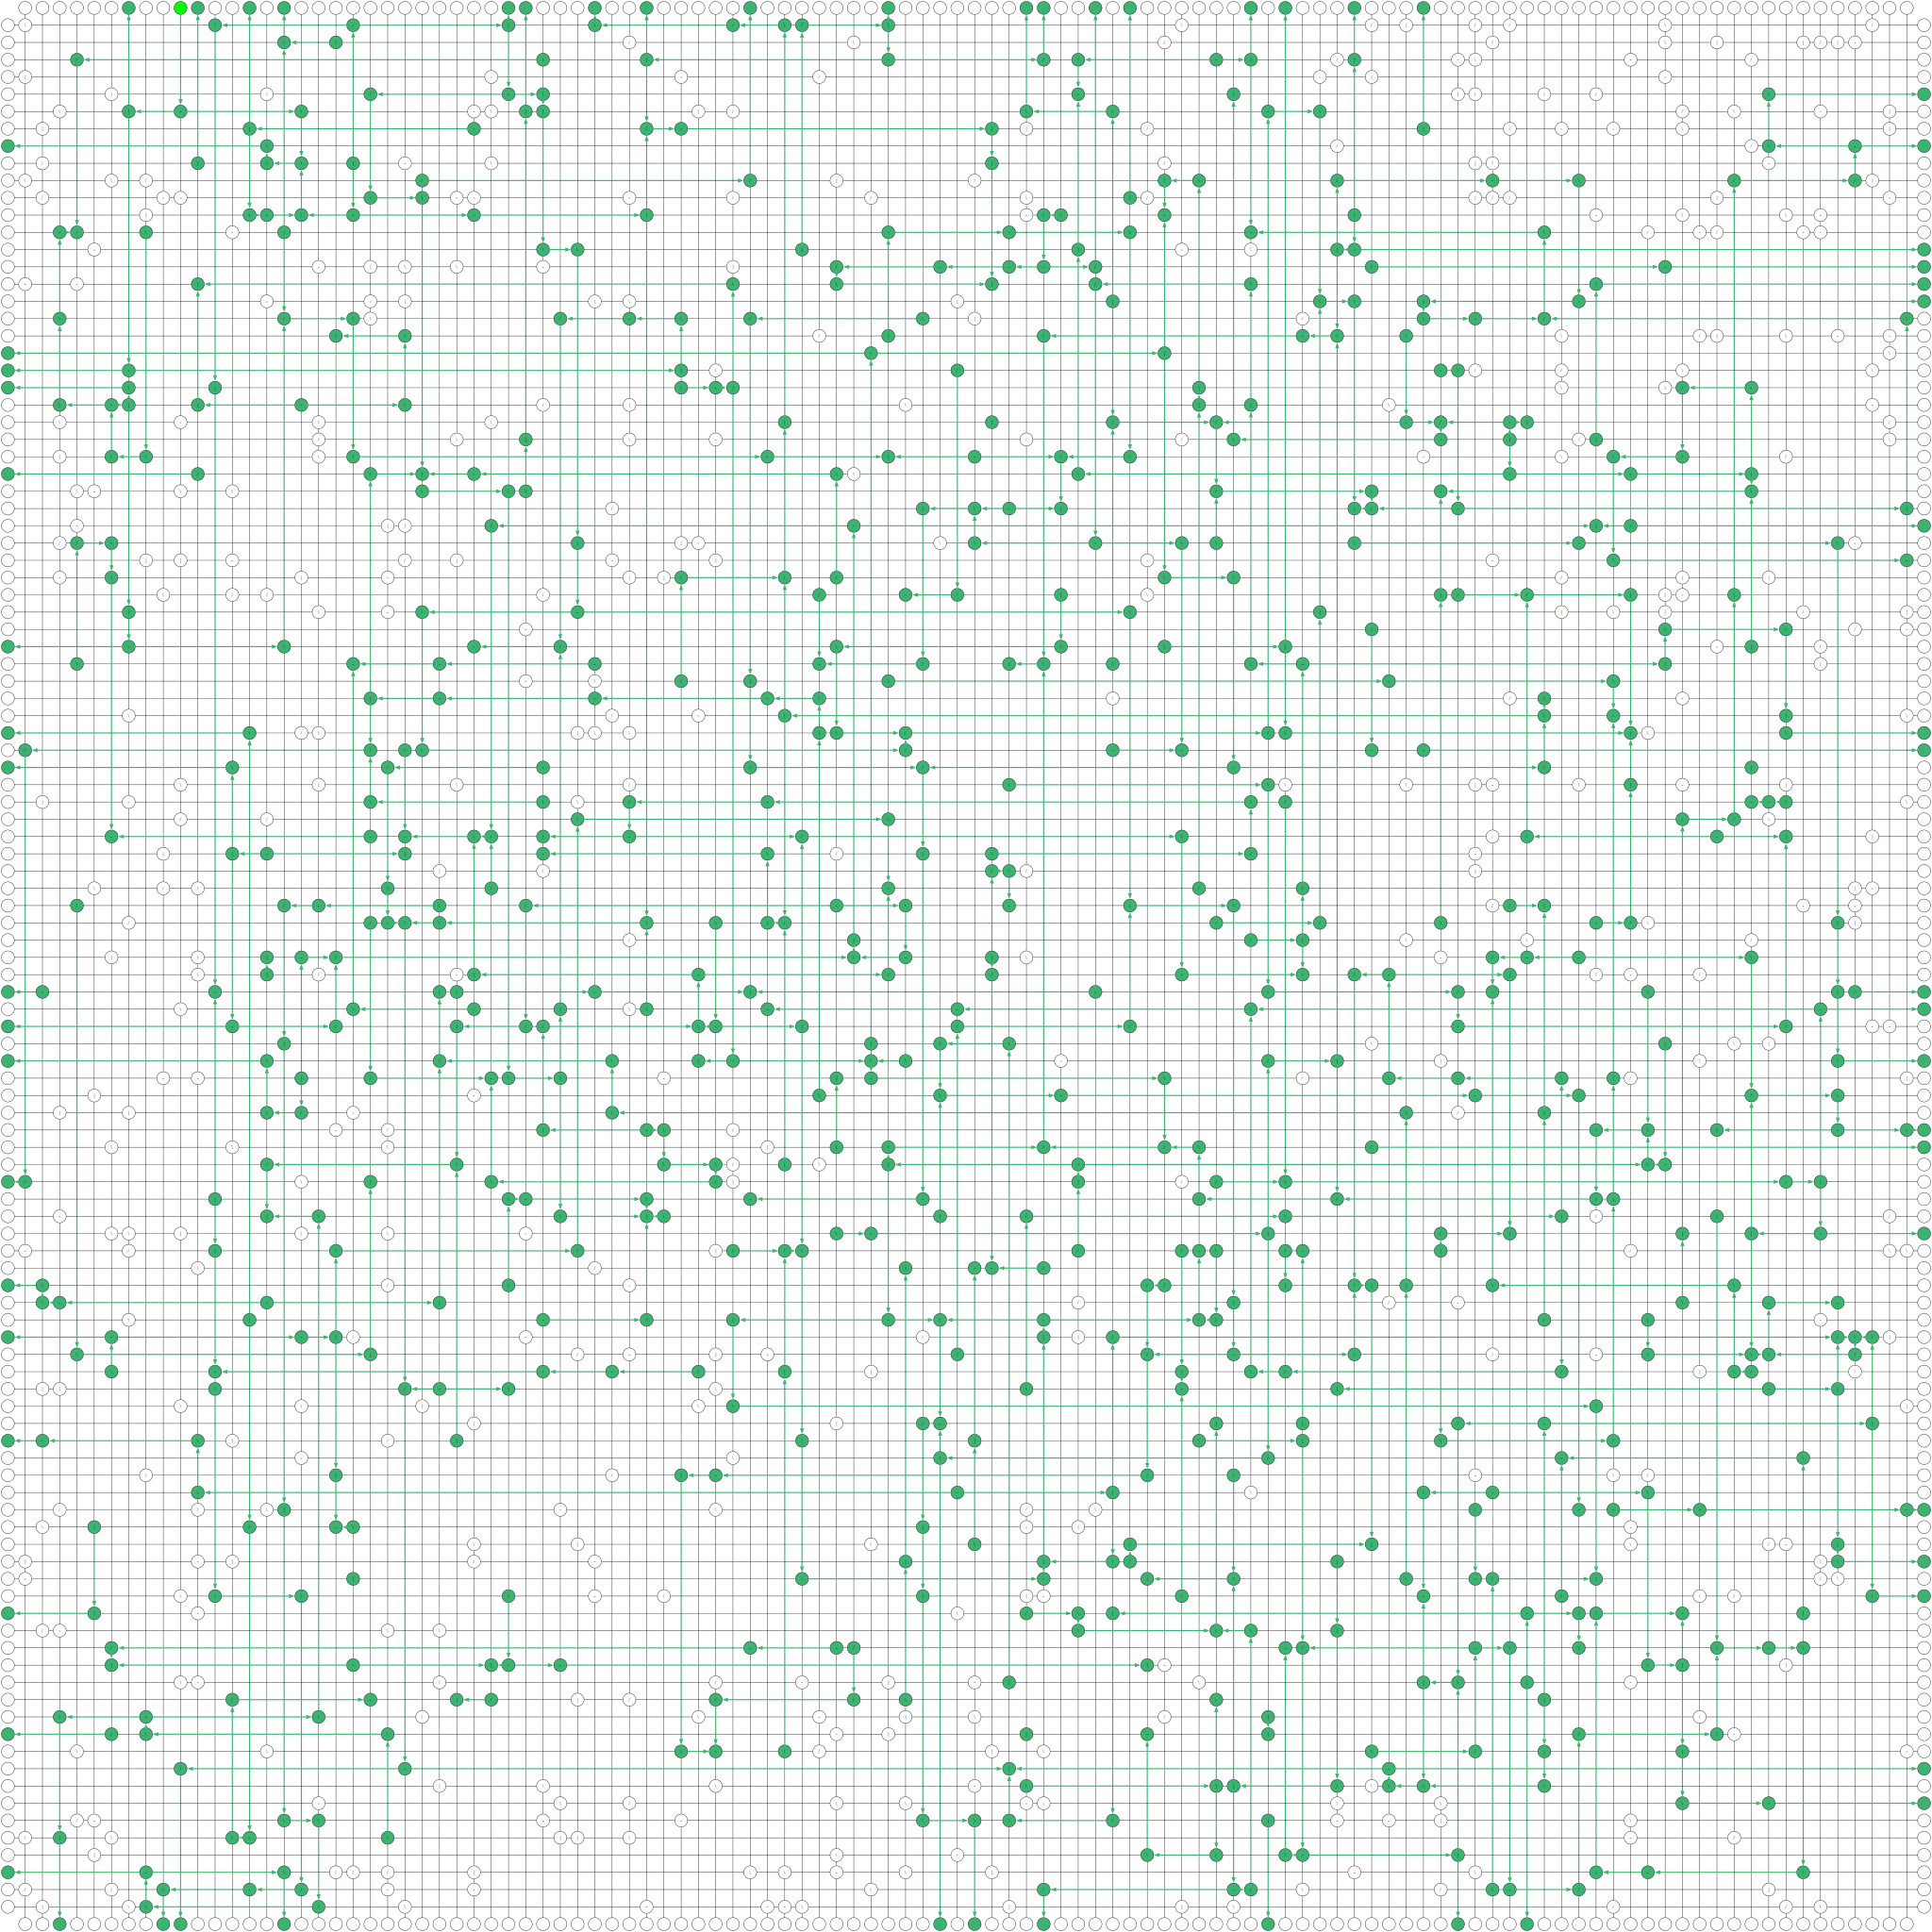

In [3]:
from graphviz import Graph

g = Graph('G', engine='neato', strict=True)
for n in nodes:
    g.node(f'{n.x} {n.y}', label=f'{n.type if n.type != '\\' else '\\\\'}', shape='circle', pos=f'{n.x/1.5},{(len(m)+1-n.y)/1.5}!')

    if n == startEdge[1]:
        g.node(f'{n.x} {n.y}', style='filled', fillcolor='lime')
        
        [g.edge(f'{n.x} {n.y}', f'{c.x} {c.y}', color='mediumseagreen', penwidth='3', dir='forward' if d in [Direction.DOWN, Direction.RIGHT] else 'back') for d, c in n.connected.items()]
    if (n.x, n.y) in energized:
        _, targets = energized[(n.x, n.y)]
        g.node(f'{n.x} {n.y}', style='filled', fillcolor='mediumseagreen')
        for d, c in targets:
            if isinstance(c, Passthrough):
                g.node(f'{c.x} {c.y}', style='filled', fillcolor='mediumseagreen')
            g.edge(f'{n.x} {n.y}', f'{c.x} {c.y}', color='mediumseagreen', penwidth='3', dir='forward' if d in [Direction.DOWN, Direction.RIGHT] else 'back')
    for d, c in n.connected.items():
        # if d in [Direction.DOWN, Direction.RIGHT]:
        g.edge(f'{n.x} {n.y}', f'{c.x} {c.y}')
    
g.attr(size=f'{len(m[0])/2},{len(m)/2}')
g